# Branch 4: 하이퍼파라미터 튜닝 (XGBoost)

## 🎯 분석 목적
XGBoost의 최적 하이퍼파라미터를 찾아 성능 극대화

## 📊 실험 배경

### **Branch 1~3 결과**

```
Branch 1: 모델 선택
  → XGBoost 선정 (RMSE 72.29)

Branch 2: 전처리 효과 ⭐⭐⭐⭐⭐
  → RUL Clipping (RMSE 16.23, -77.5% 개선!)

Branch 3: 스케일링
  → StandardScaler 확정 (TCN은 20.03)
  → XGBoost는 스케일링 무관
```

### **Branch 4 전략**

**현재 성능**: RMSE 16.23 (Branch 2)

**목표**: 하이퍼파라미터 튜닝으로 15.8~16.0 달성

---

## 🔬 GridSearch 전략

### **고정 조건**
- **모델**: XGBoost
- **전처리**: RUL Clipping ≤ 125
- **센서**: 21개 전체
- **스케일링**: StandardScaler

### **튜닝 파라미터 (주요 3개)**

#### **1. n_estimators (트리 개수)**
```python
탐색 범위: [300, 500, 700, 900]

의미:
  - 앙상블할 트리의 개수
  - 많을수록: 성능 ↑, 과적합 위험 ↑, 시간 ↑
  - 적을수록: 속도 ↑, 과적합 ↓, 성능 ↓

현재: 500 (Branch 2)
```

#### **2. max_depth (트리 깊이)**
```python
탐색 범위: [5, 7, 9, 11]

의미:
  - 각 트리의 최대 깊이
  - 깊을수록: 복잡한 패턴 학습, 과적합 위험 ↑
  - 얕을수록: 단순한 패턴, 과적합 ↓, 성능 ↓

현재: 7 (Branch 2)
```

#### **3. learning_rate (학습률)**
```python
탐색 범위: [0.01, 0.03, 0.05, 0.07]

의미:
  - 각 트리의 기여도 (shrinkage)
  - 낮을수록: 천천히 학습, 안정적, 많은 트리 필요
  - 높을수록: 빠른 학습, 불안정, 적은 트리로 충분

현재: 0.05 (Branch 2)
```

### **평가 방법**
- **5-Fold Cross Validation**
- **평가 지표**: RMSE (neg_root_mean_squared_error)
- **최종 검증**: Test Set으로 성능 측정

In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [3]:
# 한글 폰트 설정
import matplotlib.font_manager as fm

font_path = '/content/drive/MyDrive/ML project/NanumGothic-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로 설정
DATA_PATH = '/content/drive/MyDrive/ML project'

# Branch 2 최적 전처리
RUL_THRESHOLD = 125

In [4]:
# 데이터 로드
train_original = pd.read_csv(f'{DATA_PATH}/train_df.csv')
test_original = pd.read_csv(f'{DATA_PATH}/test_df.csv')

# 센서 컬럼
SENSOR_COLS = [col for col in train_original.columns if col.startswith('s_')]

In [5]:
# 전처리 (Branch 2 최적)
train_processed = train_original.copy()
test_processed = test_original.copy()

# RUL Clipping
train_processed['RUL'] = train_processed['RUL'].clip(upper=RUL_THRESHOLD)
test_processed['RUL'] = test_processed['RUL'].clip(upper=RUL_THRESHOLD)

# StandardScaler
scaler = StandardScaler()
train_scaled = train_processed.copy()
test_scaled = test_processed.copy()

scaler.fit(train_processed[SENSOR_COLS])
train_scaled[SENSOR_COLS] = scaler.transform(train_processed[SENSOR_COLS])
test_scaled[SENSOR_COLS] = scaler.transform(test_processed[SENSOR_COLS])

# 데이터 분리
X_train = train_scaled[SENSOR_COLS].values
y_train = train_scaled['RUL'].values
X_test = test_scaled[SENSOR_COLS].values
y_test = test_scaled['RUL'].values


## Section 1: Baseline 모델 (Branch 2 재현)

GridSearch 전에 현재 파라미터로 성능 확인

In [6]:
# Branch 2 파라미터
baseline_params = {
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.05,
    'random_state': 42,
    'n_jobs': -1
}

# 학습
model_baseline = XGBRegressor(**baseline_params)
model_baseline.fit(X_train, y_train, verbose=False)

# 예측
y_pred_train = model_baseline.predict(X_train)
y_pred_test = model_baseline.predict(X_test)

# 평가
train_rmse_baseline = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2_baseline = r2_score(y_test, y_pred_test)
overfit_gap_baseline = test_rmse_baseline - train_rmse_baseline


## Section 2: GridSearchCV

64개 조합을 5-Fold CV로 평가 (총 320회 학습)

In [7]:
# 파라미터 그리드 정의
param_grid = {
    'n_estimators': [300, 500, 700, 900],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.01, 0.03, 0.05, 0.07]
}

In [8]:
# Base 모델
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

# 학습
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.07],
                         'max_depth': [5, 7, 9, 11],
                         'n_estimators': [300, 500, 700, 900]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [9]:
# GridSearch 결과 분석

# 최적 파라미터
best_params = grid_search.best_params_
best_cv_score = -grid_search.best_score_  # RMSE (음수를 양수로)

print(f'\n최고 CV RMSE: {best_cv_score:.2f}')
print(f'Baseline RMSE: {test_rmse_baseline:.2f}')
print(f'CV 개선: {test_rmse_baseline - best_cv_score:.2f} ({((test_rmse_baseline - best_cv_score) / test_rmse_baseline * 100):+.2f}%)')


최고 CV RMSE: 18.11
Baseline RMSE: 16.23
CV 개선: -1.87 (-11.53%)


In [10]:
# 상위 10개 조합
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results['mean_test_rmse'] = -cv_results['mean_test_score']
cv_results['mean_train_rmse'] = -cv_results['mean_train_score']
cv_results['overfit_gap'] = cv_results['mean_test_rmse'] - cv_results['mean_train_rmse']

top_10 = cv_results.nsmallest(10, 'mean_test_rmse')[[
    'param_n_estimators', 'param_max_depth', 'param_learning_rate',
    'mean_train_rmse', 'mean_test_rmse', 'overfit_gap'
]]

print(top_10.to_string(index=False))

 param_n_estimators  param_max_depth  param_learning_rate  mean_train_rmse  mean_test_rmse  overfit_gap
                500                5                 0.07        15.472850       18.106550     2.633700
                700                5                 0.05        15.493506       18.112328     2.618822
                900                5                 0.05        15.080501       18.116484     3.035983
                700                5                 0.07        14.916624       18.116890     3.200266
                900                5                 0.03        15.849879       18.117931     2.268052
                500                7                 0.03        14.660944       18.130381     3.469438
                700                7                 0.03        14.015968       18.137346     4.121378
                500                5                 0.05        15.949087       18.138947     2.189860
                900                5                 0.07       


## Section 3: 최적 모델 평가

최적 파라미터로 Test Set 평가

In [11]:
# 최적 모델 (GridSearch가 이미 학습)
model_best = grid_search.best_estimator_

# 예측
y_pred_train_best = model_best.predict(X_train)
y_pred_test_best = model_best.predict(X_test)

# 평가
train_rmse_best = np.sqrt(mean_squared_error(y_train, y_pred_train_best))
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_test_best))
test_mae_best = mean_absolute_error(y_test, y_pred_test_best)
test_r2_best = r2_score(y_test, y_pred_test_best)
overfit_gap_best = test_rmse_best - train_rmse_best

In [12]:
# Baseline vs 최적 모델 비교
comparison = pd.DataFrame({
    'Model': ['Baseline (Branch 2)', 'Optimized (Branch 4)'],
    'n_estimators': [baseline_params['n_estimators'], best_params['n_estimators']],
    'max_depth': [baseline_params['max_depth'], best_params['max_depth']],
    'learning_rate': [baseline_params['learning_rate'], best_params['learning_rate']],
    'Train_RMSE': [train_rmse_baseline, train_rmse_best],
    'Test_RMSE': [test_rmse_baseline, test_rmse_best],
    'Overfit_Gap': [overfit_gap_baseline, overfit_gap_best]
})

comparison

# 개선율
improvement = test_rmse_baseline - test_rmse_best
improvement_pct = (improvement / test_rmse_baseline) * 100

print(f'Test RMSE 개선: {improvement:.2f} ({improvement_pct:+.2f}%)')
print(f'Overfit Gap 변화: {overfit_gap_best - overfit_gap_baseline:+.2f}')

if improvement > 0.5:
    print('\n 하이퍼파라미터 튜닝 효과 있음!')
elif improvement > 0:
    print('\n 약간 개선됨 (이미 거의 최적이었음)')
else:
    print('\n→ Baseline이 이미 최적 (변화 없음)')

Test RMSE 개선: 0.01 (+0.06%)
Overfit Gap 변화: -1.73

 약간 개선됨 (이미 거의 최적이었음)



## Section 4: 파라미터 영향 분석

In [13]:
# 각 파라미터별 평균 RMSE
for param in ['param_n_estimators', 'param_max_depth', 'param_learning_rate']:
    print(f'\n{param}:')
    grouped = cv_results.groupby(param)['mean_test_rmse'].agg(['mean', 'min', 'max'])
    print(grouped.to_string())


param_n_estimators:
                         mean        min        max
param_n_estimators                                 
300                 18.466271  18.145720  20.032475
500                 18.350559  18.106550  18.966763
700                 18.351631  18.112328  18.757206
900                 18.369179  18.116484  18.801563

param_max_depth:
                      mean        min        max
param_max_depth                                 
5                18.395524  18.106550  20.032475
7                18.252272  18.130381  18.853897
9                18.358463  18.192212  18.644112
11               18.531383  18.329844  18.801563

param_learning_rate:
                          mean        min        max
param_learning_rate                                 
0.01                 18.519161  18.152147  20.032475
0.03                 18.285482  18.117931  18.557522
0.05                 18.327451  18.112328  18.682979
0.07                 18.405547  18.106550  18.801563


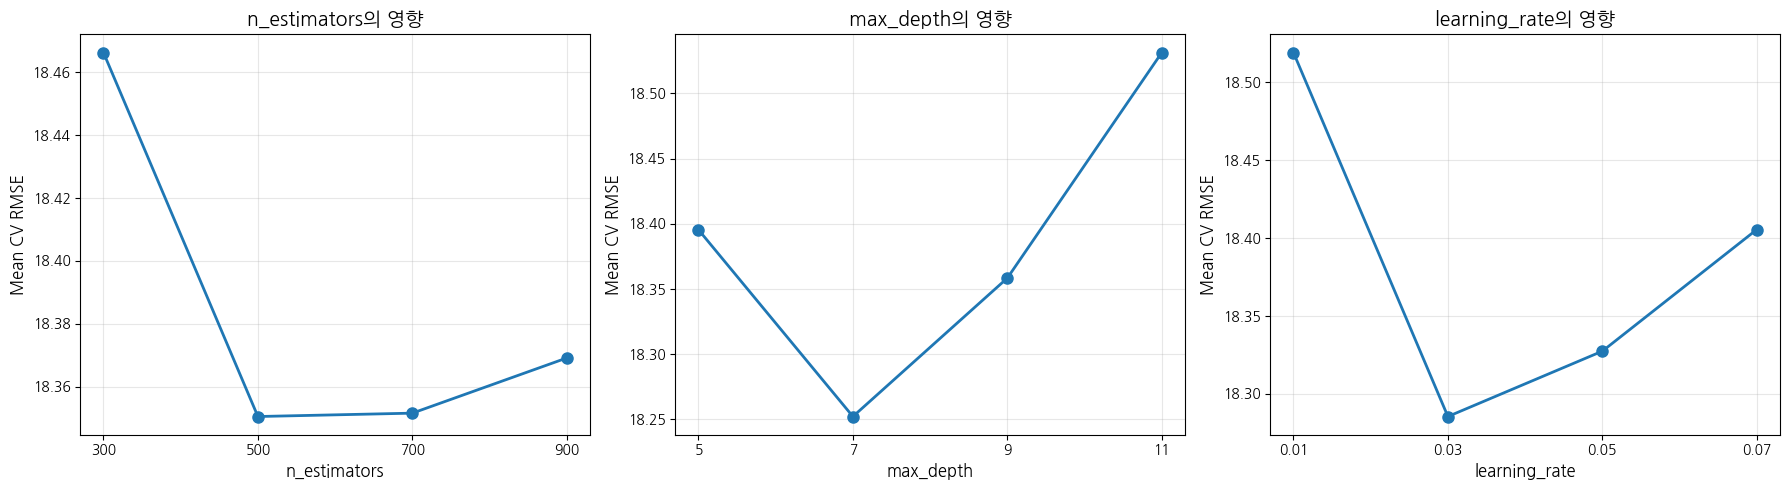

In [23]:
# 시각화 1: 파라미터별 성능
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

params = ['param_n_estimators', 'param_max_depth', 'param_learning_rate']
titles = ['n_estimators', 'max_depth', 'learning_rate']

for ax, param, title in zip(axes, params, titles):
    grouped = cv_results.groupby(param)['mean_test_rmse'].mean().sort_index()

    ax.plot(grouped.index.astype(str), grouped.values, 'o-', linewidth=2, markersize=8)
    ax.set_xlabel(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean CV RMSE', fontsize=12, fontweight='bold')
    ax.set_title(f'{title}의 영향', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

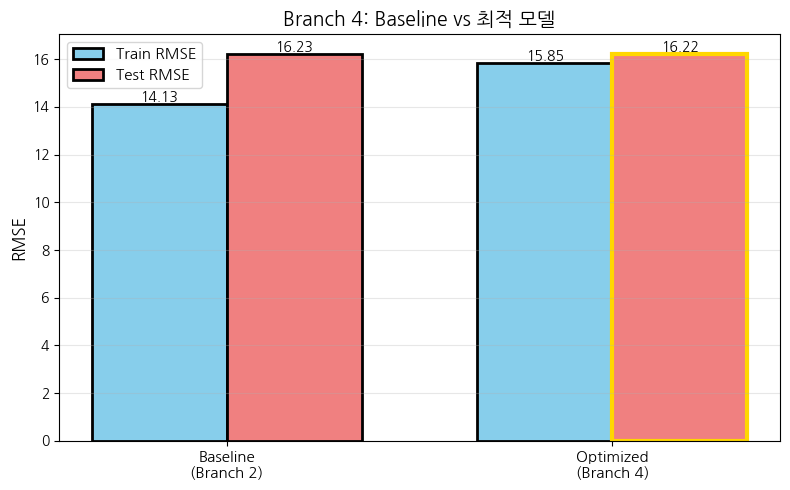

In [24]:
# 시각화 2: Baseline vs 최적 모델
fig, ax = plt.subplots(figsize=(8, 5))

models = ['Baseline\n(Branch 2)', 'Optimized\n(Branch 4)']
train_rmses = [train_rmse_baseline, train_rmse_best]
test_rmses = [test_rmse_baseline, test_rmse_best]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_rmses, width, label='Train RMSE', color='skyblue', edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, test_rmses, width, label='Test RMSE', color='lightcoral', edgecolor='black', linewidth=2)

# 최고 성능 표시
if test_rmse_best < test_rmse_baseline:
    bars2[1].set_edgecolor('gold')
    bars2[1].set_linewidth(3)

ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('Branch 4: Baseline vs 최적 모델', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

# 값 표시
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## Section 5: 특징 중요도 분석

In [16]:
# 특징 중요도 추출
feature_importance = pd.DataFrame({
    'feature': SENSOR_COLS,
    'importance': model_best.feature_importances_
}).sort_values('importance', ascending=False)

print('\n상위 10개 센서:')
print(feature_importance.head(10).to_string(index=False))

print('\n하위 5개 센서:')
print(feature_importance.tail(5).to_string(index=False))


상위 10개 센서:
feature  importance
   s_13    0.350511
   s_11    0.132399
   s_15    0.124029
    s_4    0.061794
   s_14    0.050604
    s_9    0.041031
   s_12    0.039084
   s_10    0.037390
    s_7    0.033621
    s_8    0.031563

하위 5개 센서:
feature  importance
   s_21     0.00638
    s_1     0.00098
    s_5     0.00000
   s_19     0.00000
   s_18     0.00000


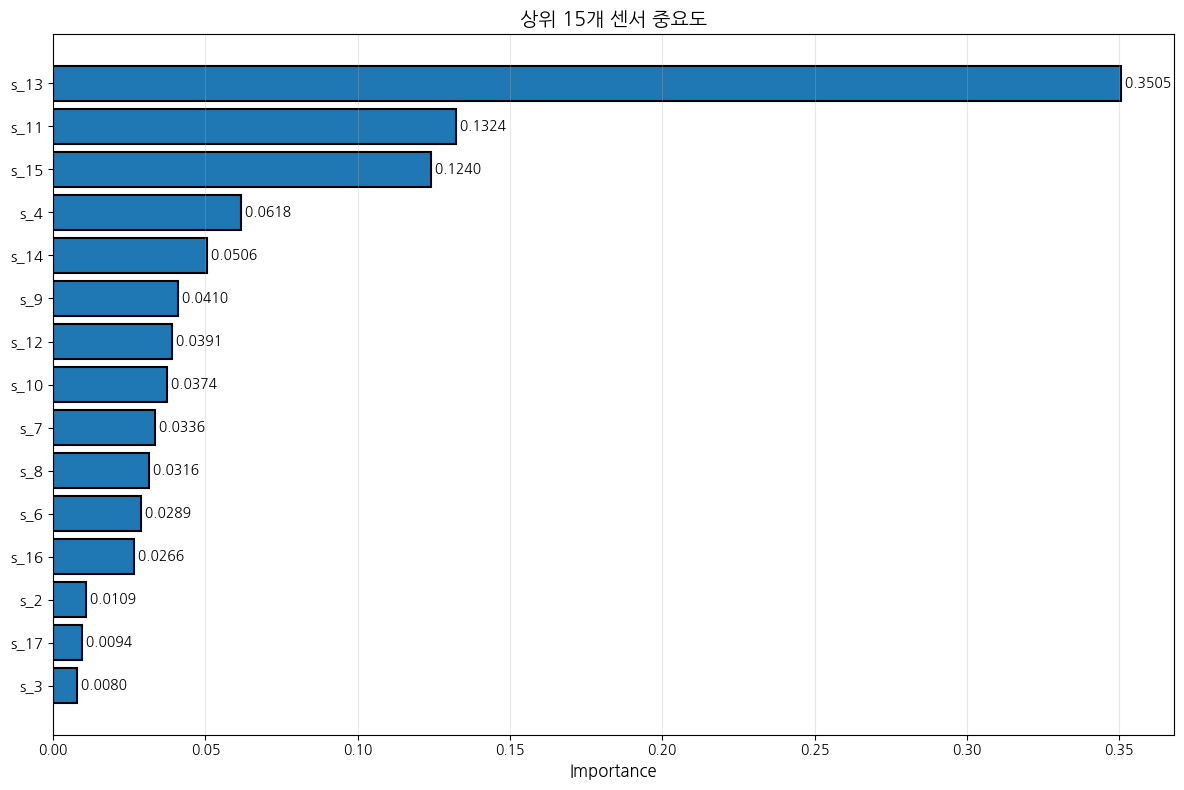

In [22]:
# 특징 중요도 시각화
fig, ax = plt.subplots(figsize=(12, 8))

top_15 = feature_importance.head(15)

bars = ax.barh(range(len(top_15)), top_15['importance'], edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'], fontsize=11, fontweight='bold')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('상위 15개 센서 중요도', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

# 값 표시
for i, (bar, val) in enumerate(zip(bars, top_15['importance'])):
    ax.text(val, bar.get_y() + bar.get_height()/2,
           f' {val:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## Section 6: 최종 결과 및 Branch 5 준비

In [18]:
# 결과 저장
df_comparison = pd.DataFrame([
    {'model': 'Baseline', 'test_rmse': test_rmse_baseline, 'overfit_gap': overfit_gap_baseline},
    {'model': 'Optimized', 'test_rmse': test_rmse_best, 'overfit_gap': overfit_gap_best}
])

df_comparison.to_csv(f'{DATA_PATH}/branch4_results.csv', index=False)
cv_results.to_csv(f'{DATA_PATH}/branch4_gridsearch_results.csv', index=False)
feature_importance.to_csv(f'{DATA_PATH}/branch4_feature_importance.csv', index=False)